SETTING UP THE ENVIRONMENT

In [1]:
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import numpy as np
import pathlib
import os
from random import shuffle
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Activation, Dense,Conv2D, MaxPooling2D,Flatten, Dropout, BatchNormalization, GlobalMaxPool2D
from tensorflow.keras.models import Sequential



In [2]:
# Extracting Paths

my_path = '/Users/radhikasingh/Desktop/Data Science/practice/train/'
all_paths = os.listdir('/Users/radhikasingh/Desktop/Data Science/practice/train/')
all_paths[:10]

['dog.8011.jpg',
 'cat.5077.jpg',
 'dog.7322.jpg',
 'cat.2718.jpg',
 'cat.10151.jpg',
 'cat.3406.jpg',
 'dog.1753.jpg',
 'cat.4369.jpg',
 'cat.7660.jpg',
 'dog.5535.jpg']

In [3]:
shuffle(all_paths)

In [4]:
# Removing Bad Quality Images

def TestImageQuality(all_paths):
    new_all_paths = []
    for path in tqdm(all_paths):
        try:
            new_path = my_path + path
            image = tf.io.read_file(new_path)
            image = tf.io.decode_jpeg(image, channels = 3)
        except Exception as e:
            print(e)
            continue
        new_all_paths.append(new_path)
    return new_all_paths

paths = TestImageQuality(all_paths)
    

100%|██████████| 25000/25000 [02:51<00:00, 146.12it/s]


In [5]:
paths[:10]

['/Users/radhikasingh/Desktop/Data Science/practice/train/dog.6874.jpg',
 '/Users/radhikasingh/Desktop/Data Science/practice/train/cat.6491.jpg',
 '/Users/radhikasingh/Desktop/Data Science/practice/train/cat.3089.jpg',
 '/Users/radhikasingh/Desktop/Data Science/practice/train/cat.9017.jpg',
 '/Users/radhikasingh/Desktop/Data Science/practice/train/dog.12299.jpg',
 '/Users/radhikasingh/Desktop/Data Science/practice/train/dog.246.jpg',
 '/Users/radhikasingh/Desktop/Data Science/practice/train/cat.8210.jpg',
 '/Users/radhikasingh/Desktop/Data Science/practice/train/dog.10823.jpg',
 '/Users/radhikasingh/Desktop/Data Science/practice/train/dog.6623.jpg',
 '/Users/radhikasingh/Desktop/Data Science/practice/train/cat.2546.jpg']

In [6]:
# Getting Labels (Cat, Dog)

def get_labels(paths):
    labels = []
    for path in tqdm(paths):
        labels.append(path.split('/')[-1].split('.')[0])
        
    return labels

labels = get_labels(paths)
labels[:10]

100%|██████████| 25000/25000 [00:00<00:00, 106521.14it/s]


['dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'dog', 'dog', 'cat']

In [7]:
# Encoding our Lables (Dog : 1, Cat : 0)

encoder = LabelEncoder()
labels = encoder.fit_transform(labels)

In [8]:
labels

array([1, 0, 0, ..., 1, 0, 0])

In [9]:
# Train - Test Split

train_paths, val_paths, train_labels, val_labels = train_test_split(paths, labels, test_size = 0.2, random_state=42)



In [10]:
# Making Tensor object

def load(image, label):
 
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels = 3)
    return image, label
    
    

In [11]:
# Creating Two layers One for Augmentation & Resizing

IMG_SIZE = 224
BATCH_SIZE = 128

resize = keras.Sequential([
    keras.layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE)
])

data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    keras.layers.experimental.preprocessing.RandomRotation(0.2),
    keras.layers.experimental.preprocessing.RandomZoom(height_factor = (-0.3, -0.2))
])

In [12]:
# Forming Tensor Dataset to fit for our moodeling process

AUTOTUNE = tf.data.experimental.AUTOTUNE

def get_dataset(paths, labels, train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)
    
    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)
    dataset = tf.data.Dataset.zip((image_dataset, label_dataset))
    
    dataset = dataset.map(lambda image,label: load(image, label))
    dataset = dataset.map(lambda image,label: (resize(image), label), num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)
    
    if train:
        dataset = dataset.map(lambda image,label: (data_augmentation(image), label), num_parallel_calls=AUTOTUNE)
        dataset = dataset.repeat()
    
    return dataset

    
    
    

In [13]:
train_dataset = get_dataset(train_paths, train_labels)
image, label = next(iter(train_dataset))
image.shape, label.shape

(TensorShape([128, 224, 224, 3]), TensorShape([128]))

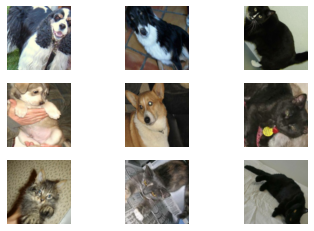

In [14]:
for i in range(9):
 
 plt.subplot(3,3,i+1)
 plt.imshow(((image[i].numpy())/255).reshape(224,224,3))
 plt.grid(False)
 plt.axis('off')


In [15]:
val_dataset = get_dataset(val_paths, val_labels, train = False)


In [16]:
# Creating Convolution layer with padding then Pooling

model = Sequential()

#Block - 0
model.add(Conv2D(input_shape = (224, 224, 3), padding = 'same', filters = 32, kernel_size = (7,7)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

#Block - 1
model.add(Conv2D(padding = 'valid', filters = 64, kernel_size = (5,5)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

#Block - 2
model.add(Conv2D(padding = 'valid',filters = 128, kernel_size = (3,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

#Block - 3
model.add(Conv2D(padding = 'valid',filters = 256, kernel_size = (3,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

#Block - 4
model.add(Conv2D(filters = 256, kernel_size = (3,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(GlobalMaxPool2D())

model.add(Dense(units = 256))
model.add(Activation('relu'))
model.add(Dropout((0.2)))


model.add(Dense(units = 1))
model.add(Activation('sigmoid'))

In [17]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      4736      
_________________________________________________________________
activation (Activation)      (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 108, 64)      51264     
_________________________________________________________________
activation_1 (Activation)    (None, 108, 108, 64)     

In [18]:
model.compile(
   loss = 'binary_crossentropy',
   optimizer = 'adam',
   metrics = ['accuracy']
)


In [20]:
history = model.fit(
    train_dataset, 
    steps_per_epoch=len(train_paths)/BATCH_SIZE,
    epochs = 5,
    validation_data=val_dataset,
    verbose=1
                   )

Epoch 1/5
156/156 [==============================] - 4326s 28s/step - loss: 0.8155 - accuracy: 0.5910 - val_loss: 0.6931 - val_accuracy: 0.5294
Epoch 2/5
156/156 [==============================] - 4090s 26s/step - loss: 0.5946 - accuracy: 0.6827 - val_loss: 0.6343 - val_accuracy: 0.6164
Epoch 3/5
156/156 [==============================] - 3535s 23s/step - loss: 0.5493 - accuracy: 0.7239 - val_loss: 0.6546 - val_accuracy: 0.6464
Epoch 4/5
156/156 [==============================] - 4502s 29s/step - loss: 0.5277 - accuracy: 0.7359 - val_loss: 0.5394 - val_accuracy: 0.7122
Epoch 5/5
156/156 [==============================] - 3271s 21s/step - loss: 0.4726 - accuracy: 0.7763 - val_loss: 0.5064 - val_accuracy: 0.7510


In [21]:
loss, acc = model.evaluate(val_dataset)
print({
    'loss' : loss,
    'acc' : acc
})

40/40 [==============================] - 191s 5s/step - loss: 0.5064 - accuracy: 0.7510
{'loss': 0.5064208507537842, 'acc': 0.7509999871253967}


In [25]:
# Training Resnet model through transfer learning and keeping top layers as False

from tensorflow.keras.applications import ResNet50V2, InceptionV2


backbone = ResNet50V2(
   input_shape = (224,224,3),
   include_top = False
)

model_Resnet = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])


94674944/94668760 [==============================] - 65s 1us/step


In [26]:
model_Resnet.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2049      
Total params: 23,566,849
Trainable params: 23,521,409
Non-trainable params: 45,440
_________________________________________________________________


In [27]:
model_Resnet.compile(
   loss = 'binary_crossentropy',
   optimizer = 'adam',
   metrics = ['accuracy']
)


In [30]:
history = model_Resnet.fit(
    train_dataset, 
    steps_per_epoch=10,
    epochs = 5,
    validation_data=val_dataset,
    verbose=1
                   )

Epoch 1/5
10/10 [==============================] - 1186s 121s/step - loss: 0.3993 - accuracy: 0.8477 - val_loss: 38.0359 - val_accuracy: 0.5128
Epoch 2/5
10/10 [==============================] - 1115s 116s/step - loss: 0.3601 - accuracy: 0.8609 - val_loss: 5.7655 - val_accuracy: 0.4922
Epoch 3/5
10/10 [==============================] - 1113s 116s/step - loss: 0.3256 - accuracy: 0.8594 - val_loss: 12.1716 - val_accuracy: 0.4948
Epoch 4/5
10/10 [==============================] - 1113s 116s/step - loss: 0.2675 - accuracy: 0.8930 - val_loss: 3.1125 - val_accuracy: 0.6104
Epoch 5/5
10/10 [==============================] - 1113s 116s/step - loss: 0.2113 - accuracy: 0.9062 - val_loss: 4.6464 - val_accuracy: 0.5612


In [34]:
loss_Resnet, acc_Resnet = model_Resnet.evaluate(val_dataset)
print({
    'loss' : loss_Resnet,
    'acc' : acc_Resnet
})


40/40 [==============================] - 442s 11s/step - loss: 4.6464 - accuracy: 0.5612
{'loss': 4.646364688873291, 'acc': 0.5612000226974487}


In [35]:
# Training Inception model through transfer learning and keeping top layers as False


backbone = InceptionV3(
   input_shape = (224,224,3),
   include_top = False
)

model_Inception = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])


In [ ]:
model_Inception.summary()

In [ ]:
model_Inception.compile(
   loss = 'binary_crossentropy',
   optimizer = 'adam',
   metrics = ['accuracy']
)


In [ ]:
history = model_Inception.fit(
    train_dataset, 
    steps_per_epoch=10,
    epochs = 5,
    validation_data=val_dataset,
    verbose=1
                   )

In [ ]:
loss_Inception, acc_Inception = model_Inception.evaluate(val_dataset)
print({
    'loss' : loss_Inception,
    'acc' : acc_Inception
})

In [54]:
# Comparing the Performance of Pre-Trained Models and Our own base Model
Comparison = {
            'Base_model' :  [loss,acc],
            'Resnet_model': [loss_Resnet, acc_Resnet],
            'Inception_model': [loss_Inception, acc_Inception] 
    
}
MODELS = pd.DataFrame(Comparison)


In [55]:
MODELS

,Base_model,Resnet_model,Inception_model
0,0.506421,0.106421,0.083421
1,0.751000,0.954654,0.949875
